In [1]:
from css_utility import *

/home/lee/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### First, save the long-version of css

In [2]:
df_pickle_path="../database/roadmap/df_pickled"

In [3]:
df_pickle_path_test_cell=df_pickle_path+"/E001_df_pickled.pkl"

In [4]:
with open(df_pickle_path_test_cell, "rb") as f:
    test_cell_df=pickle.load(f) # one long 

In [5]:
len(test_cell_df)

510150

In [13]:
def remove_chrM_and_trim_gene_file_accordingly(whole_gene_file,df):
    
    ########### new fancy gene table without overlap ###########
    g_df_chr_lst=whGene2GLChr(whole_gene_file)  ##### fixed June 29. 2023
    new_gene_lst_all=merge_intervals(g_df_chr_lst) ##### fixed June 29. 2023
    ############################################################

    #### Remove chrM ###########################################
    contains_chrM = df['chromosome'].str.contains('chrM').any()  #check whether it contains M
    if contains_chrM:
        df= df[~df['chromosome'].str.contains('chrM')]

    contains_chrY = df['chromosome'].str.contains('chrY').any()

    ##### if the target file does not contain Y, remove Y in the gene list file
    if not contains_chrY:
        new_gene_lst_all=new_gene_lst_all[:-1] ## the final element is for Y
    ############################################################

    assert len(df["chromosome"].unique())==len(new_gene_lst_all)
    return new_gene_lst_all, df

In [14]:
new_gene_lst_all, df_wo_chrM=remove_chrM_and_trim_gene_file_accordingly(whole_gene_file,test_cell_df)

Extracting the gene file ...
Done!


In [23]:
df_wo_chrM["chromosome"].str.contains('chrM')

0         False
1         False
2         False
3         False
4         False
          ...  
510145    False
510146    False
510147    False
510148    False
510149    False
Name: chromosome, Length: 510142, dtype: bool

In [25]:
css_long_test=df2longcss(df_wo_chrM)

In [27]:
type(css_long_test[0])

str

In [35]:
new_gene_lst_all[0]["TxStart"]

0           11873
1           30365
2           34610
3           69090
4          134772
          ...    
2055    249104650
2056    249120575
2057    249132376
2058    249144202
2059    249200441
Name: TxStart, Length: 2060, dtype: int64

In [37]:
css_long_test[0][11873:11973]

'OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO'

In [81]:
def ext_TSS_by_loc(whole_gene_file, df, up_num=2000, down_num=4000, gene_init=2000, unit=200):
    """
    extract TSS region by location estimation. 
    input: (1) whole_gene_file: the raw gene bed file (2) df: per cell (3) up_num: upstream (4) down_num: downstream (5) gene_init: how long the initial region would be
    output: (1) gene_start_lst_all: only gene start point per chr (2) tss_by_loc_css_unit_all: window_based (3) 
    """
    new_gene_lst_all, trimmed_df = remove_chrM_and_trim_gene_file_accordingly(whole_gene_file, df)
    
    css_lst_chr = df2longcss(trimmed_df) # list of long css per chromosome
    total_chr = len(new_gene_lst_all)
    
    gene_start_lst_all = []
    tss_by_loc_css_all = []
    tss_by_init_css_all = []
    for i in range(total_chr):
        gene_start_lst = new_gene_lst_all[i]["TxStart"]
        gene_start_lst_all.append(gene_start_lst) ### Gene start point only
        css_lst = css_lst_chr[i]
        
        tss_by_loc_css_chr = []
        tss_by_init_css_chr = []
        for j in range(len(gene_start_lst)):
            gene_start = gene_start_lst[j]
            win_start = max(0, gene_start - up_num)  # use max to prevent negative index
            win_end = min(len(css_lst), gene_start + down_num)  # use min to prevent index out of range

            tss_by_loc_css = css_lst[win_start:win_end]
            tss_by_loc_css_chr.append(tss_by_loc_css)
            
            tss_by_init_css = css_lst[gene_start:gene_start+gene_init]
            tss_by_init_css_chr.append(tss_by_init_css)
            
        tss_by_loc_css_all.append(tss_by_loc_css_chr)
        tss_by_init_css_all.append(tss_by_init_css_chr)
        
    tss_by_loc_css_unit_all=Convert2unitCSS_main_new(tss_by_loc_css_all, unit=unit)  
    tss_by_init_css_unit_all=Convert2unitCSS_main_new(tss_by_init_css_all,unit=unit)
        
    return gene_start_lst_all, tss_by_loc_css_unit_all, tss_by_init_css_unit_all   

In [82]:
gene_start_lst_all, tss_by_loc_css_unit_all, tss_by_init_css_unit_all =ext_TSS_by_loc(whole_gene_file, df_wo_chrM)

Extracting the gene file ...
Done!


In [85]:
len(tss_by_init_css_unit_all[0][0])

10

In [90]:
tss_by_init_css_unit_all[0][27]

'NNNNNNNNNN'

In [91]:
flat_tss_by_init=flatLst(tss_by_init_css_unit_all)

In [102]:
len(flat_tss_by_init)

21148

In [106]:
flat_tss_by_init[23].count("A")

7

### So, how long the Active TSS marks ("A"s) are, in the first 2kb region

In [112]:
tss_in_init=[]
for init_pos in flat_tss_by_init:
    if "A" in init_pos:
        tss_len=init_pos.count("A")*200
        tss_in_init.append(tss_len)

In [113]:
len(tss_in_init)

5847

<Axes: ylabel='Count'>

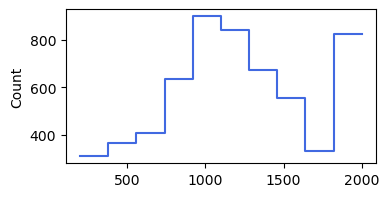

In [143]:
plt.figure(figsize=(4,2))
# sns.violinplot(tss_in_init,color="skyblue")
sns.histplot(tss_in_init,bins=10,color="royalblue", fill=False, element="step")

### And then, how are the other chromatin states in the initial position

In [136]:
from collections import Counter

# Let's suppose this is your dataset
# dataset = ["ABCDEFGHIJ", "ABCDKLMNOP", "OABCDEFGHI", "ABCDEFGHIJ", "AAAAAOOOOO"]
dataset=flat_tss_by_init

# Flatten the dataset into a single string
data_str = "".join(dataset)

# Count occurrences of each character
char_counts = Counter(data_str)

# Initialize the dictionary for the characters from "A" to "O"
counts = {chr(i+65): 0 for i in range(15)}

# Update the counts for the characters found in the data
counts.update(char_counts)

print(counts)


{'A': 34746, 'B': 3424, 'C': 939, 'D': 7491, 'E': 42583, 'F': 707, 'G': 8284, 'H': 1083, 'I': 1992, 'J': 12863, 'K': 1032, 'L': 1897, 'M': 9541, 'N': 14291, 'O': 70598}


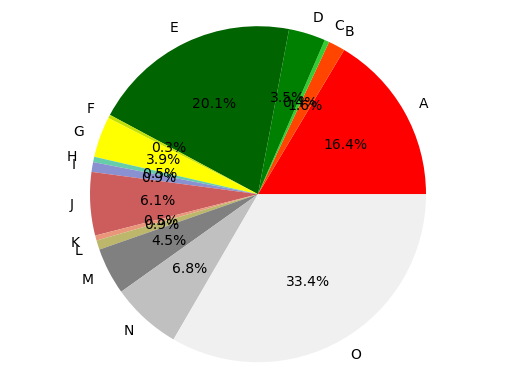

In [148]:
fig, ax = plt.subplots()
ax.pie(counts.values(), labels=counts.keys(), colors=[state_col_dict[key] for key in counts.keys()], autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### Overall, how many genes have Active TSS ("A") in a sample cell

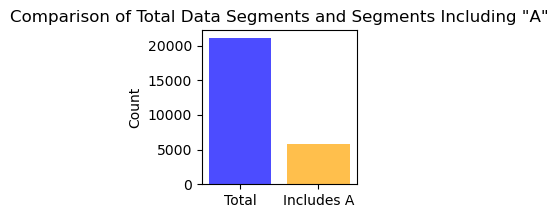

In [167]:
import matplotlib.pyplot as plt

total =len(flat_tss_by_init)
includes_A = len(tss_in_init)  # adjust as per your actual data

# Define labels, positions, bar heights and colors
labels = ['Total', 'Includes A']
x_pos = range(len(labels))
counts = [total, includes_A]
colors = ['blue', 'orange']

# Create bar chart
plt.figure(figsize=(2,2))
plt.bar(x_pos, counts, align='center', alpha=0.7, color=colors)
plt.xticks(x_pos, labels)
plt.ylabel('Count')
plt.title('Comparison of Total Data Segments and Segments Including "A"')

# Show the chart
plt.show()



## Now turn to "windowed" version

### how long Active TSS marks ("A"s) are, in -2kb to 4kb?

In [151]:
# gene_start_lst_all, tss_by_loc_css_unit_all, tss_by_init_css_unit_all are the result from the previous function

In [157]:
tss_by_loc_css_unit_all[5][30]

'EEEEEEGAAAAAAAAAAABGEEEEEEEEEE'

In [158]:
tss_by_init_css_unit_all[5][30]

'AAAAAAAABG'

In [159]:
win_tss_all=flatLst(tss_by_loc_css_unit_all)

In [162]:
tss_in_win=[]
for init_pos in win_tss_all:
    if "A" in init_pos:
        tss_win_len=init_pos.count("A")*200
        tss_in_win.append(tss_win_len)

In [165]:
len(tss_in_win)

6893

<Axes: ylabel='Count'>

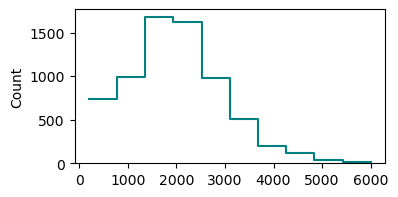

In [164]:
plt.figure(figsize=(4,2))
# sns.violinplot(tss_in_init,color="skyblue")
sns.histplot(tss_in_win,bins=10,color="teal", fill=False, element="step")

### And then, how are the other chromatin states in the initial position

In [169]:
from collections import Counter

# Let's suppose this is your dataset
# dataset = ["ABCDEFGHIJ", "ABCDKLMNOP", "OABCDEFGHI", "ABCDEFGHIJ", "AAAAAOOOOO"]
dataset=win_tss_all

# Flatten the dataset into a single string
data_str = "".join(dataset)

# Count occurrences of each character
char_counts = Counter(data_str)

# Initialize the dictionary for the characters from "A" to "O"
counts = {chr(i+65): 0 for i in range(15)}

# Update the counts for the characters found in the data
counts.update(char_counts)

print(counts)

{'A': 68196, 'B': 8498, 'C': 1985, 'D': 24180, 'E': 146932, 'F': 2203, 'G': 29035, 'H': 2957, 'I': 7512, 'J': 24909, 'K': 2649, 'L': 5844, 'M': 29799, 'N': 52944, 'O': 226783}


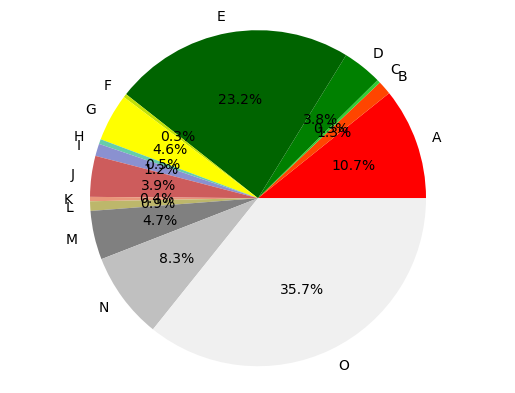

In [170]:
fig, ax = plt.subplots()
ax.pie(counts.values(), labels=counts.keys(), colors=[state_col_dict[key] for key in counts.keys()], autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### Overall, how many genes have Active TSS ("A") in a sample cell

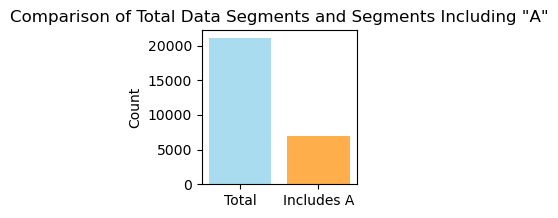

In [171]:
import matplotlib.pyplot as plt

total =len(win_tss_all)
includes_A = len(tss_in_win)  # adjust as per your actual data

# Define labels, positions, bar heights and colors
labels = ['Total', 'Includes A']
x_pos = range(len(labels))
counts = [total, includes_A]
colors = ['skyblue', 'darkorange']

# Create bar chart
plt.figure(figsize=(2,2))
plt.bar(x_pos, counts, align='center', alpha=0.7, color=colors)
plt.xticks(x_pos, labels)
plt.ylabel('Count')
plt.title('Comparison of Total Data Segments and Segments Including "A"')

# Show the chart
plt.show()

## Per genic region, how many (a sequential) promoters are there

In [7]:
import re
from collections import defaultdict, OrderedDict

def css_freq_len(strings, unit=200):
    result = defaultdict(lambda: {'count': [], 'lengths': []})
    for string in strings:  # Iterate over each string in the list
        for char in set(string):  # loop through unique characters in the string
            pattern = re.compile(f'{char}+')
            matches = pattern.findall(string)
            count = len(matches)
            lengths = [len(match)*unit for match in matches]  # multiplied by unit to make it real length
            result[char]['count'].append(count)
            result[char]['lengths'].extend(lengths)  # Use extend instead of append here
    result = dict(result)
    # Sort dictionary
    sorted_result = OrderedDict(sorted(result.items()))
    return sorted_result

strings = ["EDDDDEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE",
           "DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDEFFBAAAAAAAAAAAAAAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEDDDDDDDDDDDDDDDDDEEEEEEEE",
           "EEEEEEEEEEEEEEEEEEEEEEEEEEE"]
result = css_freq_len(strings)
print(result)



OrderedDict([('A', {'count': [1], 'lengths': [2800]}), ('B', {'count': [1], 'lengths': [200]}), ('D', {'count': [1, 2], 'lengths': [800, 7200, 3400]}), ('E', {'count': [2, 3, 1], 'lengths': [200, 12400, 200, 6200, 1600, 5400]}), ('F', {'count': [1], 'lengths': [400]})])


In [227]:
with open("../database/roadmap/gene_css_unit_pickled/E001_gene_css_pickled.pkl","rb") as f:
    css_unit_lst=pickle.load(f)

In [248]:
def gene_css_freq_len(css_unit_lst):
    css_unit_flt=flatLst(css_unit_lst)
    sorted_result=css_freq_len(css_unit_flt)
    return sorted_result

In [249]:
sorted_result=gene_css_freq_len(css_unit_lst)

In [255]:
a_len=sorted_result["A"]["lengths"]

<Axes: ylabel='Count'>

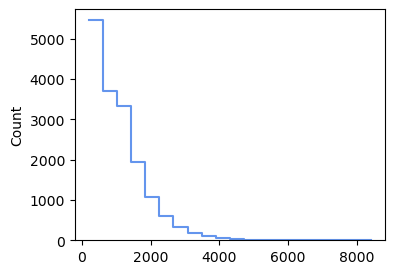

In [290]:
plt.figure(figsize=(4,3))
sns.histplot(a_len, color="cornflowerblue",bins=20, element="step", fill=False)

In [266]:
a_count=sorted_result["A"]["count"]

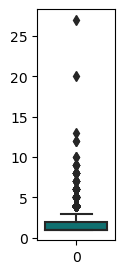

In [305]:
plt.figure(figsize=(1,3))
# sns.boxplot(a_count, color="teal",boxprops=dict(edgecolor="white"))
sns.boxplot(a_count, color="teal")
plt.show()

In [8]:
import pandas as pd

def css_freq_len(strings, unit=200):
    result = defaultdict(lambda: {'count': [], 'lengths': []})
    for string in strings:  # Iterate over each string in the list
        for char in set(string):  # loop through unique characters in the string
            pattern = re.compile(f'{char}+')
            matches = pattern.findall(string)
            count = len(matches)
            lengths = [len(match)*unit for match in matches]  # multiplied by unit to make it real length
            result[char]['count'].append(count)
            result[char]['lengths'].extend(lengths)  # Use extend instead of append here
    result = dict(result)
    # Sort dictionary
    sorted_result = OrderedDict(sorted(result.items()))

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(sorted_result).transpose()  # transpose to have letters as the index

    return df

strings = ["EDDDDEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE",
           "DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDEFFBAAAAAAAAAAAAAAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEDDDDDDDDDDDDDDDDDEEEEEEEE",
           "EEEEEEEEEEEEEEEEEEEEEEEEEEE"]
result = css_freq_len(strings)
print(result)


       count                              lengths
A        [1]                               [2800]
B        [1]                                [200]
D     [1, 2]                    [800, 7200, 3400]
E  [2, 3, 1]  [200, 12400, 200, 6200, 1600, 5400]
F        [1]                                [400]


In [307]:
def css_freq_len(strings, unit=200):
    result = defaultdict(lambda: {'count': [], 'lengths': []})
    for string in strings:  # Iterate over each string in the list
        for char in set(string):  # loop through unique characters in the string
            pattern = re.compile(f'{char}+')
            matches = pattern.findall(string)
            count = len(matches)
            lengths = [len(match)*unit for match in matches]  # multiplied by unit to make it real length
            result[char]['count'].append(count)
            result[char]['lengths'].extend(lengths)  # Use extend instead of append here
    result = dict(result)
    # Sort dictionary
    sorted_result = OrderedDict(sorted(result.items()))
    return sorted_result

strings = ["EDDDDEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE",
           "DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDEFFBAAAAAAAAAAAAAAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEDDDDDDDDDDDDDDDDDEEEEEEEE",
           "EEEEEEEEEEEEEEEEEEEEEEEEEEE"]
result = css_freq_len(strings)

# Transform into DataFrame
df = pd.DataFrame({k: pd.Series(v['lengths']) for k, v in result.items()})


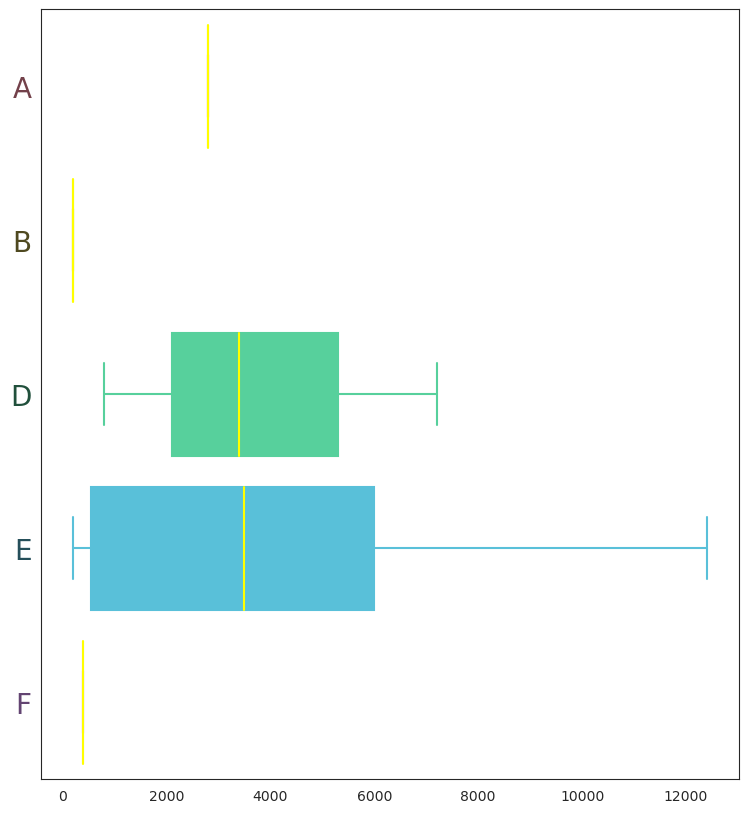

In [308]:
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb, to_rgb
import seaborn as sns
import pandas as pd
import numpy as np

# Function to enlighten color
def enlighten(color, factor=0.5):
    h, s, v = rgb_to_hsv(to_rgb(color))
    return hsv_to_rgb((h, s, 1 - factor * (1 - v)))

# Function to endarken color
def endarken(color, factor=0.5):
    h, s, v = rgb_to_hsv(to_rgb(color))
    return hsv_to_rgb((h, s, factor * v))

# Load data
result = css_freq_len(strings)

# Flatten lengths and transform data to suitable format
df = pd.DataFrame({key: pd.Series(value['lengths']) for key, value in result.items()})

sns.set_style('white')
fig, ax = plt.subplots(figsize=(9, 10))

colors = sns.color_palette("husl", len(df.columns))
sns.boxplot(data=df, orient="h", showfliers=False, palette='husl',
            medianprops=dict(color="yellow", label='median'), ax=ax)
box_container = ax.patches if len(ax.patches) > 0 else ax.artists
lines_per_boxplot = len(ax.lines) // len(box_container)
for i, (box, ytick) in enumerate(zip(box_container, ax.get_yticklabels())):
    ytick.set_color(endarken(box.get_facecolor()))
    ytick.set_fontsize(20)
    color = enlighten(box.get_facecolor())
    box.set_color(color)
    for lin in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        if lin.get_label() != 'median':
            lin.set_color(color)


In [309]:
state_col_dict

{'A': (1.0, 0.0, 0.0),
 'B': (1.0, 0.27058823529411763, 0.0),
 'C': (0.19607843137254902, 0.803921568627451, 0.19607843137254902),
 'D': (0.0, 0.5019607843137255, 0.0),
 'E': (0.0, 0.39215686274509803, 0.0),
 'F': (0.7607843137254902, 0.8823529411764706, 0.0196078431372549),
 'G': (1.0, 1.0, 0.0),
 'H': (0.4, 0.803921568627451, 0.6666666666666666),
 'I': (0.5411764705882353, 0.5686274509803921, 0.8156862745098039),
 'J': (0.803921568627451, 0.3607843137254902, 0.3607843137254902),
 'K': (0.9137254901960784, 0.5882352941176471, 0.47843137254901963),
 'L': (0.7411764705882353, 0.7176470588235294, 0.4196078431372549),
 'M': (0.5019607843137255, 0.5019607843137255, 0.5019607843137255),
 'N': (0.7529411764705882, 0.7529411764705882, 0.7529411764705882),
 'O': (0.9411764705882353, 0.9411764705882353, 0.9411764705882353)}

In [9]:
import pandas as pd
from collections import defaultdict
import re

def css_freq_len(strings, unit=200):
    result = defaultdict(lambda: {'count': [], 'lengths': [], 'relative_position': []})
    for string in strings:  # Iterate over each string in the list
        total_length = len(string)
        for char in set(string):  # loop through unique characters in the string
            pattern = re.compile(f'{char}+')
            matches = pattern.findall(string)
            count = len(matches)
            lengths = [len(match)*unit for match in matches]  # multiplied by unit to make it real length
            for match in matches:
                relative_position = round(((string.index(match) / total_length) * 100) + 1, 2)
                result[char]['relative_position'].append(relative_position)
            result[char]['count'].append(count)
            result[char]['lengths'].extend(lengths)  # Use extend instead of append here
    result = dict(result)
    # Sort dictionary
    sorted_result = OrderedDict(sorted(result.items()))

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(sorted_result).transpose()  # transpose to have letters as the index

    return df

strings = ["EDDDDEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE",
           "DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDEFFBAAAAAAAAAAAAAAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEDDDDDDDDDDDDDDDDDEEEEEEEE",
           "EEEEEEEEEEEEEEEEEEEEEEEEEEE"]
result = css_freq_len(strings)
print(result)


       count                              lengths  \
A        [1]                               [2800]   
B        [1]                                [200]   
D     [1, 2]                    [800, 7200, 3400]   
E  [2, 3, 1]  [200, 12400, 200, 6200, 1600, 5400]   
F        [1]                                [400]   

                       relative_position  
A                                [37.36]  
B                                [36.45]  
D                       [2.49, 1.0, 1.0]  
E  [1.0, 8.46, 33.73, 50.09, 50.09, 1.0]  
F                                [34.64]  


In [10]:
with open("../database/roadmap/gene_css_unit_pickled/E001_gene_css_pickled.pkl","rb") as f:
    g_e001=pickle.load(f)

In [12]:
g_e001_all=flatLst(g_e001)

In [16]:
df_g_e001=css_freq_len(strings, unit=200)

In [17]:
df_g_e001

,count,lengths,relative_position
A,[1],[2800],[37.36]
B,[1],[200],[36.45]
D,"[1, 2]","[800, 7200, 3400]","[2.49, 1.0, 1.0]"
E,"[2, 3, 1]","[200, 12400, 200, 6200, 1600, 5400]","[1.0, 8.46, 33.73, 50.09, 50.09, 1.0]"
F,[1],[400],[34.64]


In [63]:
def shorten_string(s, factor):
    # This regular expression matches groups of the same character.
    pattern = re.compile(r'(.)\1*')

    # This function will be used to replace each match.
    def replacer(match):
        # The group that was matched.
        group = match.group()

        # Calculate the new length, rounding as necessary.
        new_length = round(len(group) / factor)

        # Return the character repeated the new number of times.
        return group[0] * new_length

    # Use re.sub to replace each match in the string.
    return pattern.sub(replacer, s)

In [64]:
def Convert2unitCSS_main_new(css_lst_all, unit=200):# should be either css_gene_lst_all or css_Ngene_lst_all
    """
    Input: css_gene_lst_all or css_Ngene_lst_all, the list of chromosome-wise list of the css in genic, intergenic regions.
    Output: css_gene_unit_lst_all or css_Ngene_unit_lst_all
    """
    reduced_all=[]
    for i in range(len(css_lst_all)):
        reduced_chr=[]
        for j in range(len(css_lst_all[i])):
            reduced=shorten_string(css_lst_all[i][j], unit)
            reduced_chr.append(reduced)
        reduced_all.append(reduced_chr)
    return reduced_all